In [82]:
import sys
import sktime
import tqdm as tq
import xgboost as xgb
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np

In [83]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor

pd.set_option('display.max_columns', 30)

In [140]:
base_path = "/home/jinjinjara1022/"

weather_forecast_data_1 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_1.csv")
weather_forecast_data_2 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_2.csv")  

weather_observed_data_1 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_1.csv")
weather_observed_data_2 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_2.csv")  
  
jeju_power_market_day_ahead = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_하루전가격.csv")
jeju_power_market_real_time = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_실시간가격.csv")

jeju_power_market_status = pd.read_csv(base_path + "OBIC/data/제주전력시장_현황데이터.csv")

In [141]:
weather_forecast_data_1

,location,base_ts,ts,temp,real_feel_temp,wet_bulb_temp,dew_point,wind_dir,wind_spd,wind_gust_spd,rel_hum,vis,ceiling,uv_idx,precip_prob,rain_prob,snow_prob,ice_prob,total_liq,rain,snow,ice,cld_cvr
0,Ilgwa-ri,1709258400,1709305200,3.33333,-3.88889,1.11111,-2.77778,343.0,27.8417,59.2239,64.0,16.0934,609.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0
1,Ilgwa-ri,1709258400,1709308800,3.33333,-3.88889,1.11111,-2.77778,342.0,27.8417,59.2239,64.0,16.0934,609.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0
2,Ilgwa-ri,1709258400,1709312400,3.33333,-4.44444,1.11111,-2.77778,342.0,27.8417,59.2239,65.0,16.0934,1981.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.0
3,Ilgwa-ri,1709258400,1709316000,2.77778,-4.44444,1.11111,-2.22222,341.0,29.6119,57.4536,67.0,16.0934,3596.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0
4,Ilgwa-ri,1709258400,1709319600,3.33333,-4.44444,1.11111,-2.77778,341.0,29.6119,57.4536,65.0,16.0934,4998.72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53103,Sangmo-ri,1729562400,1729681200,17.2222,15.0,13.8889,11.1111,353.0,22.2089,53.7521,66.0,16.0934,9144.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
53104,Sangmo-ri,1729562400,1729684800,17.2222,14.4444,13.8889,11.1111,356.0,22.2089,51.8209,67.0,16.0934,9144.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
53105,Sangmo-ri,1729562400,1729688400,16.6667,13.8889,13.3333,10.5556,359.0,20.4387,51.8209,69.0,16.0934,9144.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
53106,Sangmo-ri,1729562400,1729692000,16.1111,13.3333,13.3333,10.5556,2.0,20.4387,50.0506,72.0,16.0934,9144.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [85]:
weather_forecast_data_2_jeju = weather_forecast_data_2[weather_forecast_data_2['location'] == 'Jeju']

weather_forecast_data_2_jeju['hour'] = pd.to_datetime(weather_forecast_data_2_jeju['ts'], unit='s').dt.hour
weather_forecast_data_2_jeju['date'] = pd.to_datetime(weather_forecast_data_2_jeju['ts'], unit='s').dt.date

weather_forecast_data_2_jeju = weather_forecast_data_2_jeju.drop_duplicates(subset=['date', 'hour'], keep='first')

/tmp/ipykernel_110842/2080195917.py:3: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  weather_forecast_data_2_jeju['hour'] = pd.to_datetime(weather_forecast_data_2_jeju['ts'], unit='s').dt.hour
/tmp/ipykernel_110842/2080195917.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_forecast_data_2_jeju['hour'] = pd.to_datetime(weather_forecast_data_2_jeju['ts'], unit='s').dt.hour
/tmp/ipykernel_110842/2080195917.py:4: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing stri

In [86]:
jeju_power_market_day_ahead['hour'] = pd.to_datetime(jeju_power_market_day_ahead['ts'], unit='s').dt.hour
jeju_power_market_day_ahead['date'] = pd.to_datetime(jeju_power_market_day_ahead['ts'], unit='s').dt.date

In [87]:
df = pd.merge(weather_forecast_data_2_jeju, jeju_power_market_day_ahead, on=['hour', 'date'], how='left')

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665 entries, 0 to 5664
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   location      5665 non-null   object 
 1   base_ts       5665 non-null   object 
 2   ts_x          5665 non-null   object 
 3   cloud         5665 non-null   object 
 4   temp          5665 non-null   object 
 5   temp_max      5665 non-null   object 
 6   temp_min      5665 non-null   object 
 7   humidity      5665 non-null   object 
 8   ground_press  5665 non-null   object 
 9   wind_speed    5665 non-null   object 
 10  wind_dir      5665 non-null   object 
 11  rain          5665 non-null   object 
 12  snow          5665 non-null   object 
 13  hour          5665 non-null   int32  
 14  date          5665 non-null   object 
 15  ts_y          5641 non-null   float64
 16  하루전가격(원/kWh)  5641 non-null   float64
dtypes: float64(2), int32(1), object(14)
memory usage: 730.4+ KB


In [89]:
df['datetimes'] = pd.to_datetime(df['ts_x'], unit='s')
df['hour'] = df['datetimes'].dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['month'] = df['datetimes'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['day_of_week'] = df['datetimes'].dt.dayofweek
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)


df = df.drop(['datetimes', 'ts_x', 'ts_y','hour', 'month', 'day_of_week', 'location', 'date'], axis=1)
df = df[[col for col in df.columns if col != '하루전가격(원/kWh)'] + ['하루전가격(원/kWh)']]

df.rename(columns={
    '하루전가격(원/kWh)': 'previous_price_kwh'
}, inplace=True)

/tmp/ipykernel_110842/89701636.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['datetimes'] = pd.to_datetime(df['ts_x'], unit='s')


In [90]:
df['previous_day_price'] = df['previous_price_kwh'].shift(24)
df['previous_2day_price'] = df['previous_price_kwh'].shift(48)
df['previous_3day_price'] = df['previous_price_kwh'].shift(72)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665 entries, 0 to 5664
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   base_ts              5665 non-null   object 
 1   cloud                5665 non-null   object 
 2   temp                 5665 non-null   object 
 3   temp_max             5665 non-null   object 
 4   temp_min             5665 non-null   object 
 5   humidity             5665 non-null   object 
 6   ground_press         5665 non-null   object 
 7   wind_speed           5665 non-null   object 
 8   wind_dir             5665 non-null   object 
 9   rain                 5665 non-null   object 
 10  snow                 5665 non-null   object 
 11  hour_sin             5665 non-null   float64
 12  hour_cos             5665 non-null   float64
 13  month_sin            5665 non-null   float64
 14  month_cos            5665 non-null   float64
 15  day_of_week_sin      5665 non-null   f

In [92]:
df = df[100:-100]

In [93]:
df

,base_ts,cloud,temp,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir,rain,snow,hour_sin,hour_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos,previous_price_kwh,previous_day_price,previous_2day_price,previous_3day_price
100,1709604000,100.0,9.76,9.76,9.76,83.0,1012.0,7.41,51.0,0.0,0.0,-0.965926,0.258819,1.000000,6.123234e-17,0.781831,0.623490,164.31,94.80,80.97,82.66
101,1709604000,100.0,9.61,9.61,9.61,83.0,1013.0,7.22,46.0,0.0,0.0,-0.866025,0.500000,1.000000,6.123234e-17,0.781831,0.623490,164.31,94.80,80.97,82.66
102,1709604000,100.0,9.46,9.46,9.46,81.0,1013.0,6.92,47.0,0.0,0.0,-0.707107,0.707107,1.000000,6.123234e-17,0.781831,0.623490,164.31,94.80,81.81,99.15
103,1709604000,100.0,9.45,9.45,9.45,78.0,1014.0,5.97,47.0,0.0,0.0,-0.500000,0.866025,1.000000,6.123234e-17,0.781831,0.623490,164.31,105.85,166.81,165.83
104,1709604000,100.0,9.54,9.54,9.54,76.0,1015.0,5.41,50.0,0.0,0.0,-0.258819,0.965926,1.000000,6.123234e-17,0.781831,0.623490,164.31,107.38,309.13,169.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5560,1729216800,98.0,18.47,18.47,18.47,83.0,1018.0,6.07,339.0,0.0,0.0,0.965926,-0.258819,-0.866025,5.000000e-01,-0.974928,-0.222521,101.36,154.02,157.02,138.67
5561,1729216800,98.0,18.62,18.62,18.62,85.0,1019.0,5.62,357.0,0.18,0.0,0.866025,-0.500000,-0.866025,5.000000e-01,-0.974928,-0.222521,101.36,154.02,157.02,154.13
5562,1729216800,98.0,19.05,19.05,19.05,86.0,1020.0,4.99,31.0,0.16,0.0,0.707107,-0.707107,-0.866025,5.000000e-01,-0.974928,-0.222521,101.99,153.57,156.21,156.26
5563,1729216800,98.0,19.4,19.4,19.4,89.0,1020.0,11.65,66.0,1.18,0.0,0.500000,-0.866025,-0.866025,5.000000e-01,-0.974928,-0.222521,139.29,154.15,156.94,157.34


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5465 entries, 100 to 5564
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   base_ts              5465 non-null   object 
 1   cloud                5465 non-null   object 
 2   temp                 5465 non-null   object 
 3   temp_max             5465 non-null   object 
 4   temp_min             5465 non-null   object 
 5   humidity             5465 non-null   object 
 6   ground_press         5465 non-null   object 
 7   wind_speed           5465 non-null   object 
 8   wind_dir             5465 non-null   object 
 9   rain                 5465 non-null   object 
 10  snow                 5465 non-null   object 
 11  hour_sin             5465 non-null   float64
 12  hour_cos             5465 non-null   float64
 13  month_sin            5465 non-null   float64
 14  month_cos            5465 non-null   float64
 15  day_of_week_sin      5465 non-null  

In [95]:
df = df.astype(float)

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5465 entries, 100 to 5564
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   base_ts              5465 non-null   float64
 1   cloud                5465 non-null   float64
 2   temp                 5465 non-null   float64
 3   temp_max             5465 non-null   float64
 4   temp_min             5465 non-null   float64
 5   humidity             5465 non-null   float64
 6   ground_press         5465 non-null   float64
 7   wind_speed           5465 non-null   float64
 8   wind_dir             5465 non-null   float64
 9   rain                 5465 non-null   float64
 10  snow                 5465 non-null   float64
 11  hour_sin             5465 non-null   float64
 12  hour_cos             5465 non-null   float64
 13  month_sin            5465 non-null   float64
 14  month_cos            5465 non-null   float64
 15  day_of_week_sin      5465 non-null  

In [116]:
y = df['previous_price_kwh']
x = df.drop(['previous_price_kwh', 'base_ts'], axis=1)

In [117]:
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = int(len(y) * 0.1))
print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))

train data shape
x:(4919, 19), y:(4919,)


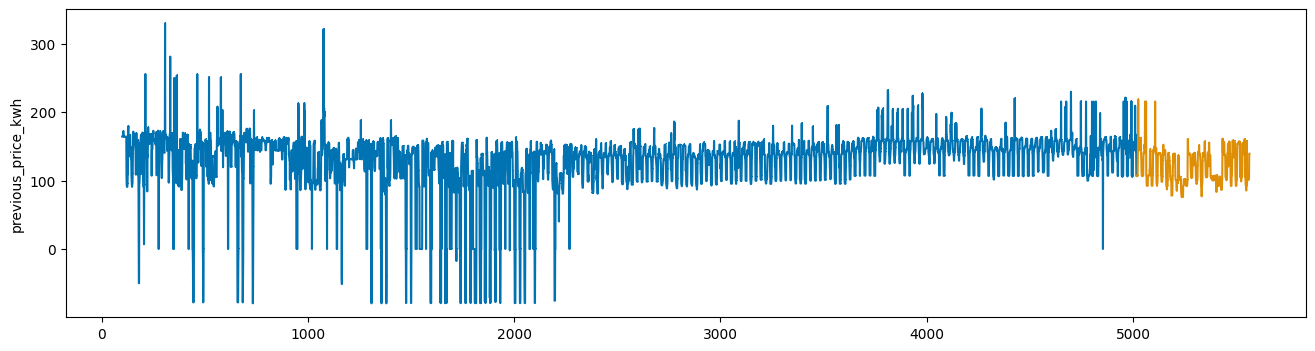

In [118]:
plot_series(y_train, y_valid, markers=[',' , ','])
plt.show()

In [119]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [120]:
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [121]:
import xgboost as xgb
print(xgb.__version__)


2.1.1


In [122]:
from xgboost import XGBRegressor

# XGBRegressor 모델 생성 (GPU 사용)
xgb_reg = XGBRegressor(
    n_estimators=4000, 
    learning_rate=0.001,      # 학습률
    min_child_weight=1,      # 최소 가중치
    max_depth=7,             # 최대 깊이
    colsample_bytree=0.8,    # 컬럼 샘플링 비율
    subsample=0.8,           # 데이터 샘플링 비율
    tree_method='hist',      # 'hist' 사용
    device='cuda',           # GPU 사용 설정
    seed=0,
    early_stopping_rounds = 500
)

xgb_reg.fit(
    x_train, y_train, 
    eval_set=[(x_train, y_train), (x_valid, y_valid)], 
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=500,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=4000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Evaluate

In [125]:
pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)

SMAPE : 5.851574350115871


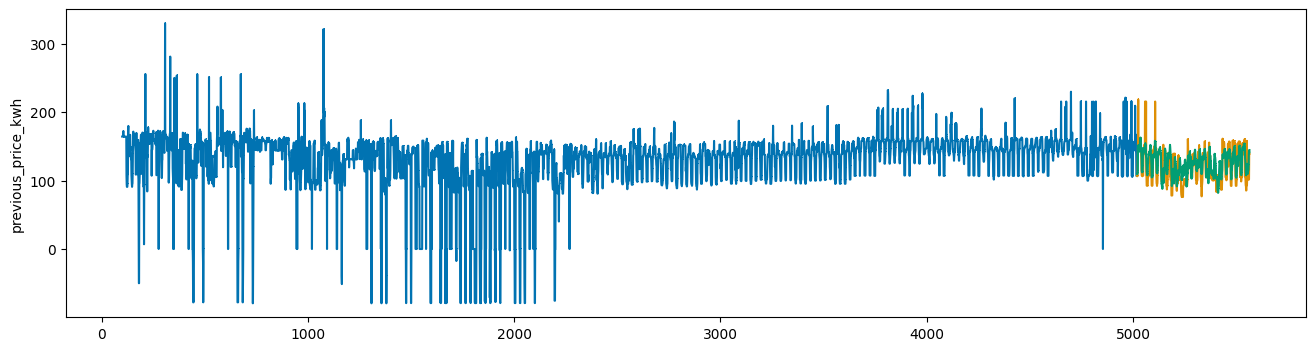

In [126]:
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

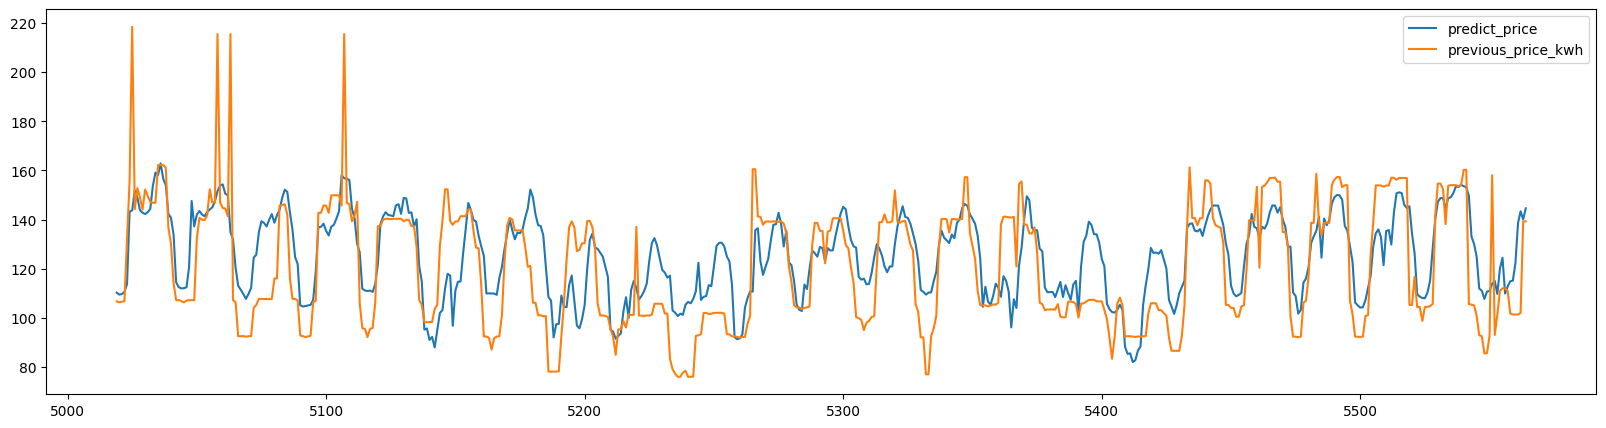

In [127]:
plt.figure(figsize=(20, 5))
pred.plot(label='predict_price')
y_valid.plot()
plt.legend()
plt.show()